# Research and comparison of classification methods on a dataset of heart diseases.
## Author: Vadym Tunik.

URL: https://archive.ics.uci.edu/ml/datasets/Heart+Disease \
Data: processed.clivelend.data, heart-disease.names

In [54]:
# general tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# sub-tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Bayesian optimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [55]:
names_list = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
              'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

data = pd.read_csv('data/processed.cleveland.data', names=names_list)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### 1. Process the data for missing values.

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


So we can see that columns 11 and 12 contain some non-numerical data, so let's remove them. \
To do this, notice that the missing data is marked as “?”.

In [57]:
data.iloc[87]

age          53.0
sex           0.0
cp            3.0
trestbps    128.0
chol        216.0
fbs           0.0
restecg       2.0
thalach     115.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal            ?
num             0
Name: 87, dtype: object

So, we need to remove the lines with “?” and convert all occurrences to a numeric data type if possible (if it is NOT possible to convert occurrences to a numeric data type, an error will occur and we will have to expand the list of character occurrences that we remove as missing values).

In [58]:
clean_data = data.replace('?', pd.NA)
clean_data = clean_data.dropna()
clean_data = clean_data.apply(pd.to_numeric)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  num       297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


![alt text](features_descryption.png)

The purpose of the dataset is to categorize patients and healthy people.\
Therefore, we change the target variable to 0 (healthy) and 1 (sick)

In [59]:
clean_data['num'] =  (clean_data['num'] >= 1).astype(int)
clean_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Now let's normalize the sample and divide the sample into test and training (without categorical features) in proportions of 20% and 80%.

In [60]:
names_list_without_categorical_and_response = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
x = clean_data[names_list_without_categorical_and_response]
y = pd.DataFrame(clean_data.iloc[:,-1])

min_max_scaler = MinMaxScaler()
x = min_max_scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2024)
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()  # apply ravel() to avoid DataConversionWarning

### 2. Naive Bayesian classifier.
https://scikit-learn.org/stable/modules/naive_bayes.html

In [84]:
classificator = GaussianNB() # use Gaussian Naive Bayes due to the continuous nature of our data
y_pred = classificator.fit(x_train, y_train).predict(x_test)

print(f"accuracy: {np.round(accuracy_score(y_test, y_pred)*100,2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

accuracy: 68.33%

confusion_matrix: 
[[24 11]
 [ 8 17]]

f1-score: 0.6852060452454707


So, we can see that our classifier is doing a terrible job.\
The accuracy is less than 70%, the f1-score is also far from 1.0, and so on. \
What does this tell us? It tells us that the assumption of the independence of the variables is far from true.

I'd also like to clarify that we will use the 'weighted' f1-score\
because this approach gives more weight to classes with more instances\
(the class with no heart disease is twice as large as the others in total).

### 3. Classification by the k-nn method, with different values of n.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

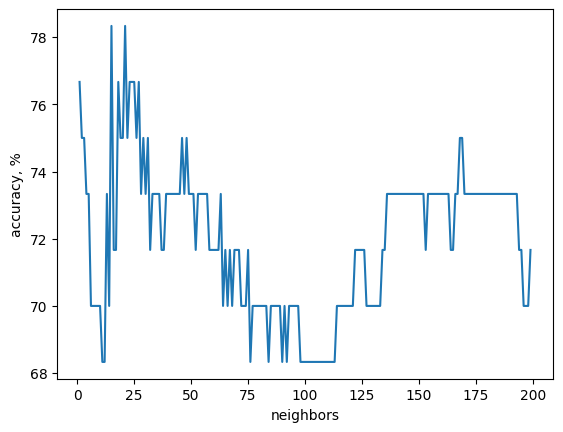

In [85]:
n_neighbors_list = np.arange(1,200)
accuracy_history = []
for n_neighbors in n_neighbors_list:
    classificator = KNeighborsClassifier(n_neighbors=n_neighbors)
    y_pred = classificator.fit(x_train, y_train).predict(x_test)

    temp_accuracy = accuracy_score(y_test, y_pred)*100
    accuracy_history.append(temp_accuracy)

plt.plot(n_neighbors_list, accuracy_history)
plt.xlabel('neighbors')
plt.ylabel('accuracy, %')
plt.show()

In [86]:
n = n_neighbors_list[np.argmax(accuracy_history)]
print(f'{n=}')

classificator = KNeighborsClassifier(n_neighbors=n)
y_pred = classificator.fit(x_train, y_train).predict(x_test)

print(f"accuracy: {np.round(accuracy_score(y_test, y_pred)*100,2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

n=15
accuracy: 78.33%

confusion_matrix: 
[[29  6]
 [ 7 18]]

f1-score: 0.782648270575836


So the maximum accuracy 78.33% is for n_neighbors=15. \
This is definitely a better result than the Naive Bayesian classifier and the best result using the k-nn method,  but we obviously want to do better.

### 4. Classification using logistic regression.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [87]:
classificator = LogisticRegression()
y_pred = classificator.fit(x_train, y_train).predict(x_test)

print(f"accuracy: {np.round(accuracy_score(y_test, y_pred)*100,2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

accuracy: 78.33%

confusion_matrix: 
[[29  6]
 [ 7 18]]

f1-score: 0.782648270575836


Unfortunately, logistic regression did not bring any improvements.\
Perhaps if we add a factor variable to it later, it will perform better.

### 5. Classification using SVM, with different kernels and hyperparameters.

https://scikit-learn.org/stable/modules/svm.html#svm-classification

In [88]:
def objective(params):
    kernel = params['kernel']
    C = params['C']

    model = SVC(kernel=kernel, C=C)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    loss  = 1 - accuracy_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'C': hp.uniform('C', 0.01, 100),
}

trials = Trials()
fmin_results = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)
best_params = space_eval(space, fmin_results)

best_model = SVC(kernel=best_params['kernel'], C=best_params['C'])
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"{best_params=}")
print(f"accuracy: {np.round(score*100,2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")


100%|██████████| 200/200 [00:12<00:00, 15.90trial/s, best loss: 0.18333333333333335]
best_params={'C': 2.3658826905080765, 'kernel': 'poly'}
accuracy: 81.67%

confusion_matrix: 
[[28  7]
 [ 4 21]]

f1-score: 0.8177508683000094


Cool, we've improved in all quality metrics. Let's see if we can do better.

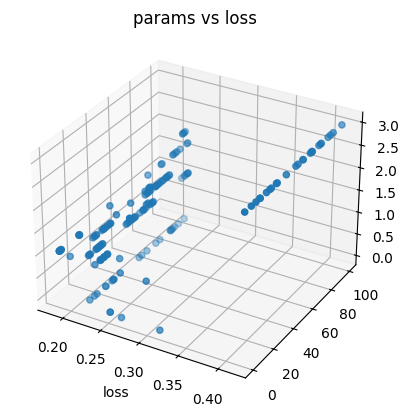

In [116]:
x = [t['result']['loss'] for t in trials.trials]
y = [t['misc']['vals']['C'] for t in trials.trials]
z = [t['misc']['vals']['kernel'] for t in trials.trials]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('loss')
_ = plt.title('params vs loss')

### 6. Classification using trees, boosting, and random forest. Different configurations.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier \
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html \
https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier

In [121]:
def objective(params):
    criterion = params['criterion']
    max_depth = params['max_depth']
    max_features = params['max_features']
    min_samples_split = params['min_samples_split']
    min_samples_leaf = params['min_samples_leaf']

    model = DecisionTreeClassifier(criterion=criterion, 
                                   max_depth=max_depth,
                                   max_features = max_features,
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    loss = 1 - accuracy_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'min_samples_split': hp.choice('min_samples_split', range(2,20)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1,5))
}

trials = Trials()
fmin_results = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials)
best_params = space_eval(space, fmin_results)

best_model = DecisionTreeClassifier(criterion=best_params['criterion'],
                                    max_depth=best_params['max_depth'],
                                    max_features=best_params['max_features'],
                                    min_samples_split=best_params['min_samples_split'],
                                    min_samples_leaf=best_params['min_samples_leaf'])
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"{best_params=}")
print(f"accuracy: {np.round(score*100,2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

100%|██████████| 300/300 [00:02<00:00, 125.98trial/s, best loss: 0.18333333333333335]
best_params={'criterion': 'gini', 'max_depth': 18, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 9}
accuracy: 81.67%

confusion_matrix: 
[[31  4]
 [ 7 18]]

f1-score: 0.8145827261245506


We got almost the same result as the previous one, but with a slightly worse f1-score.\
Let's try Gradient Boosting.

In [133]:
def objective(params):
    learning_rate = params['learning_rate']
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    min_samples_leaf = params['min_samples_leaf']
    max_features = params['max_features']
    
    model = GradientBoostingClassifier(learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    loss = 1 - accuracy_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'learning_rate': hp.choice('learning_rate', [1, 0.5, 0.25, 0.1, 0.05, 0.01]),
    'n_estimators': hp.choice('n_estimators', [1, 2, 4, 8, 16, 32, 64, 100, 200]),
    'max_depth': hp.choice('max_depth', range(1, 35)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'max_features': hp.choice('max_features', range(1,100))
}

trials = Trials()
fmin_results = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials)
best_params = space_eval(space, fmin_results)

best_model = GradientBoostingClassifier(learning_rate=best_params['learning_rate'],
                                        n_estimators=best_params['n_estimators'],
                                        max_depth=best_params['max_depth'],
                                        min_samples_split=best_params['min_samples_split'],
                                        min_samples_leaf=best_params['min_samples_leaf'],
                                        max_features=best_params['max_features'])
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"{best_params=}")
print(f"accuracy: {np.round(score*100, 2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

100%|██████████| 300/300 [00:17<00:00, 16.72trial/s, best loss: 0.18333333333333335]
best_params={'learning_rate': 0.5, 'max_depth': 17, 'max_features': 52, 'min_samples_leaf': 0.358523063923053, 'min_samples_split': 0.16869502645543236, 'n_estimators': 100}
accuracy: 81.67%

confusion_matrix: 
[[29  6]
 [ 5 20]]

f1-score: 0.8171355498721228


Still no improvement :(\
Let's try Random Forest.

In [17]:
def objective(params):
    n_estimators=params['n_estimators']
    max_depth=params['max_depth']
    max_features=params['max_features']
    criterion=params['criterion']

    model =  RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    max_features=max_features,
                                    criterion=criterion,
                                    random_state=2024)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    loss = 1 - accuracy_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'n_estimators': hp.choice('n_estimators', range(1,100)),
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

trials = Trials()
fmin_results = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=400, trials=trials)
best_params = space_eval(space, fmin_results)

best_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                    max_depth=best_params['max_depth'],
                                    max_features=best_params['max_features'],
                                    criterion=best_params['criterion'],
                                    random_state=2024)
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"{best_params=}")
print(f"accuracy: {np.round(score*100, 2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

100%|██████████| 400/400 [00:27<00:00, 14.70trial/s, best loss: 0.18333333333333335]
best_params={'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'n_estimators': 8, 'scale': 0}
accuracy: 81.67%

confusion_matrix: 
[[31  4]
 [ 7 18]]

f1-score: 0.8145827261245506


Very interesting, the same result again.\
I suspect that to improve the quality of the classification, we need factor variables.\
Let's add the factor variable "sex" to the logistic regression and all the categorical and numeric variables for the random forest.

### 7. Adding factor data to the model.
Factor variable: Column 2 - "Sex"

##### Logistic regression + factor variable.

In [99]:
names_list_with_factor= ['age', 'sex', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
x_factor = clean_data[names_list_with_factor]
x_factor = pd.get_dummies(x_factor, columns=['sex']) # one-hot encoding 
print(x_factor)
min_max_scaler = MinMaxScaler()
x_factor = min_max_scaler.fit_transform(x_factor)

      age  trestbps   chol  thalach  oldpeak   ca  sex_0.0  sex_1.0
0    63.0     145.0  233.0    150.0      2.3  0.0    False     True
1    67.0     160.0  286.0    108.0      1.5  3.0    False     True
2    67.0     120.0  229.0    129.0      2.6  2.0    False     True
3    37.0     130.0  250.0    187.0      3.5  0.0    False     True
4    41.0     130.0  204.0    172.0      1.4  0.0     True    False
..    ...       ...    ...      ...      ...  ...      ...      ...
297  57.0     140.0  241.0    123.0      0.2  0.0     True    False
298  45.0     110.0  264.0    132.0      1.2  0.0    False     True
299  68.0     144.0  193.0    141.0      3.4  2.0    False     True
300  57.0     130.0  131.0    115.0      1.2  1.0    False     True
301  57.0     130.0  236.0    174.0      0.0  1.0     True    False

[297 rows x 8 columns]


In [104]:
x_train, x_test, y_train, y_test = train_test_split(x_factor, y, test_size=0.2, random_state=2024)
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()  # apply ravel() to avoid DataConversionWarning


def objective(params):
    C = params['C']
    penalty = params['penalty']
    solver = params['solver']
    
    model = LogisticRegression(C=C,
                               penalty=penalty,
                               solver=solver)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    loss = 1 - accuracy_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}


space = {
    'C': hp.uniform('C', 0.01, 100),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'solver': hp.choice('solver', ['liblinear', 'saga'])
}

trials = Trials()
fmin_results = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1000, trials=trials)
best_params = space_eval(space, fmin_results)

best_model = LogisticRegression(C=best_params['C'],
                                penalty=best_params['penalty'],
                                solver=best_params['solver'])
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"{best_params=}")
print(f"accuracy: {np.round(score*100, 2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

100%|██████████| 1000/1000 [00:08<00:00, 115.02trial/s, best loss: 0.18333333333333335]
best_params={'C': 0.36920986412753365, 'penalty': 'l1', 'solver': 'saga'}
accuracy: 81.67%

confusion_matrix: 
[[29  6]
 [ 5 20]]

f1-score: 0.8171355498721228


Great, we got a better result compared to the previous logistic regression, but still not better than the absolute record for the accuracy.

##### Random Forest with all categorical data.

In [82]:
names_list = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
              'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
x_all = clean_data[names_list_without_categorical_and_response]

min_max_scaler = MinMaxScaler()
x_all = min_max_scaler.fit_transform(x_all)

x_train, x_test, y_train, y_test = train_test_split(x_all, y, test_size=0.2, random_state=2024)
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()  # apply ravel() to avoid DataConversionWarning

In [97]:
def objective(params):
    n_estimators=params['n_estimators']
    max_depth=params['max_depth']
    max_features=params['max_features']
    criterion=params['criterion']

    model =  RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    max_features=max_features,
                                    criterion=criterion,
                                    random_state=2024)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    loss = 1 - accuracy_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'n_estimators': hp.choice('n_estimators', range(1,100)),
    'max_depth': hp.choice('max_depth', range(1,50)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

trials = Trials()
fmin_results = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1000, trials=trials)
best_params = space_eval(space, fmin_results)

best_model = RandomForestClassifier(**best_params, random_state=2024)
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"{best_params=}")
print(f"accuracy: {np.round(score*100, 2)}%\n")
print(f"confusion_matrix: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"f1-score: {f1_score(y_test, y_pred, average='weighted')}")

100%|██████████| 1000/1000 [01:16<00:00, 13.08trial/s, best loss: 0.15000000000000002]
best_params={'criterion': 'entropy', 'max_depth': 8, 'max_features': 3, 'n_estimators': 12}
accuracy: 85.0%

confusion_matrix: 
[[30  5]
 [ 4 21]]

f1-score: 0.8503836317135549


Hooray, we got our best result - 85%. Congratulations to myself!

### 8. Conclusion.
So, in the course of our work, we explored the following methods: 
1. naive bayesian classifier - 68.33% accuracy;
2. k-nn method - 78.33% accuracy;
3. logistic regression - 78.33% accuracy;
4. SVM - 81.67% accuracy;
5. decision tree - 81.67% accuracy;
6. gradient boosting - 81.67% accuracy;
7. random forest - 81.67% accuracy;
8. logistic regression with factor variable - 81.67% accuracy;
9. random forest with all categorical data - 85.0% accuracy;

We can see that we stayed on the plateau of 81.67% accuracy for a long time,\
which can be explained by the lack of a significant amount of categorical dataset data and/or random division of the dataset at the beginning.\
However, as expected, with the addition of categorical data, the accuracy of our classifiers improved.
